In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.transforms as T
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import os
import time
import datetime


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import config

In [2]:
if config.ADSMI:
    from DL_finetune import ADSMI_DL_TVsplit as DL
    data_name = 'ADSMI'

In [3]:
#empty cuda cache
torch.cuda.empty_cache()

## Models


In [4]:
print(config.channels)

class Resnet50_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(Resnet50_Classifier, self).__init__()
        self.resnet50 = models.resnet50()
        self.resnet50.conv1 = nn.Conv2d(config.channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet50(x)
    



class ResNet101_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNet101_Classifier, self).__init__()
        self.resnet101 = models.resnet101()
        
        # Modify the first convolutional layer
        self.resnet101.conv1 = nn.Conv2d(config.channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Remove the final fully connected layer
        self.resnet101.fc = nn.Identity()  # Set the final layer to an identity mapping
        
        # Define the custom fully connected layers
        num_features = 2048 
        self.fc1 = nn.Linear(num_features, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.resnet101(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

    
class ModifiedResnet50_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedResnet50_Classifier, self).__init__()
        
        # Load the pretrained ResNet-50 model
        #self.resnet50 = models.resnet50(pretrained=True)
        self.resnet50 = models.resnet50()
        # Modify the first convolutional layer
        self.resnet50.conv1 = nn.Conv2d(config.channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Remove the final fully connected layer
        self.resnet50.fc = nn.Identity()  # Set the final layer to an identity mapping
        
        # Define the custom fully connected layers
        num_features = 2048 
        self.fc1 = nn.Linear(num_features, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.resnet50(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

3


In [5]:
#------Datasplit
# Load the dataframe
labels_file = pd.read_csv('./data/labeled_ADSMI/labels_int.csv', index_col=0)
#train_df, test_df = train_test_split(labels_file, test_size=0.2, stratify=labels_file['Label_int'], random_state=47)
#val_df = test_df
train_df, temp = train_test_split(labels_file, test_size=0.2, stratify=labels_file['Label_int'], random_state=47)
test_df, val_df = train_test_split(temp, test_size=0.5, stratify=temp['Label_int'], random_state=47)
# train test split
print("Train size: ", len(train_df))
print("Test size: ", len(test_df))
print("Val size: ", len(val_df))



print(train_df["Label_int"].value_counts())
print(test_df["Label_int"].value_counts())
print(val_df["Label_int"].value_counts())

train_loader, test_loader = DL.create_generators_finetune_train(train_df,test_df)




Train size:  3776
Test size:  472
Val size:  472
Label_int
0    1760
2    1332
1     570
3     114
Name: count, dtype: int64
Label_int
0    220
2    166
1     72
3     14
Name: count, dtype: int64
Label_int
0    220
2    167
1     71
3     14
Name: count, dtype: int64


In [6]:

#  Create an instance of the model
num_classes = len(set(labels_file["Label_int"]))  
#model = Resnet50_Classifier(num_classes)
model = ModifiedResnet50_Classifier(num_classes)
#model = ResNet101_Classifier(num_classes)

# Hyperparameters
num_epochs = config.finetune_epochs 
learning_rate = 0.0003
weight_decay = 0  # L2 regularization
batch_size = config.batch_size
patience = config.patience

#  Transfer the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay ) # Adjust the value as needed)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=6, factor=0.6, verbose=True)

#new folder path
standalone_results_path = f'./results_standalone/SA_ADSMI_{num_epochs}_epochs_{datetime.datetime.now().strftime("%Y-%m-%d-%H")}'

# Create a directory to save the results
if not os.path.exists(standalone_results_path):
    os.makedirs(standalone_results_path)

with open(f'{standalone_results_path}/log_file.txt', 'w') as log_file:
    log_file.write(f'########################################################\n')
    log_file.write(f'training on {data_name} dataset\n')
    log_file.write(f'Learning rate: {learning_rate}\n')
    log_file.write(f'Weight decay: {weight_decay}\n')
    log_file.write(f'Batch size: {batch_size}\n')
    log_file.write(f'Number of epochs: {num_epochs}\n')
    log_file.write(f'Patience: {patience}\n')
    log_file.write(f'Number of classes: {num_classes}\n')
    log_file.write(f'Train size: {len(train_df)}\n')
    log_file.write(f'Test size: {len(test_df)}\n')
    log_file.write(f'Val size: {len(val_df)}\n')
    log_file.write(f'Length of train data in seconds: {config.desired_length_in_seconds}\n')
    log_file.write(f'freq_mask_param : {config.freq_mask_param}\n')
    log_file.write(f'time_mask_param : {config.time_mask_param}\n')
    log_file.write(f'########################################################\n\n')

train_losses = []
val_losses = []
best_accuracy = 0
best_loss = 1000
early_stop_counter = 0
#config.model_path = "./results_standalone/newgpu2_checkpoint.pth"


In [7]:
for epoch in range(num_epochs):
    model.train()
    epoch_train_losses = []  # Temporary list for storing training losses for each batch
    for batch_idx, (spectrograms, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        loss = criterion(outputs, labels)
        epoch_train_losses.append(loss.item())  # Append current batch loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate average training loss for the epoch
    avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(avg_train_loss)  # Append average loss to main list

    model.eval()
    epoch_val_losses = []  # Temporary list for storing validation losses for each batch
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for spectrograms, labels in test_loader:
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            epoch_val_losses.append(loss.item())  # Append current batch loss

            # Compute the predicted labels
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    # Calculate average validation loss for the epoch
    avg_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
    val_losses.append(avg_val_loss)  # Append average loss to main list

    # Model saving and logging based on accuracy and loss
    accuracy = correct_predictions / total_samples
    if correct_predictions / total_samples > best_accuracy:
        best_accuracy = accuracy
        torch.save(model, standalone_results_path + '/checkpoint.pth')
        early_stop_counter = 0
        with open(standalone_results_path + '/log_file.txt', 'a') as log_file:
            log_file.write(f"Best accuracy improved on epoch {epoch}: {best_accuracy * 100:.2f}%\n")
    
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model, standalone_results_path + '/checkpoint_best_loss.pth')
        early_stop_counter = 0
        with open(standalone_results_path + '/log_file.txt', 'a') as log_file:
            log_file.write(f"Best loss improved on epoch {epoch}: {best_loss:.4f}\n")

    scheduler.step(avg_val_loss)

    # Logging for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {accuracy * 100:.2f}%")
    with open(standalone_results_path + '/log_file.txt', 'a') as log_file:
        log_file.write(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy}, Early stopping count: {early_stop_counter} from {patience}\n")

    # Early stopping
    early_stop_counter += 1
    if early_stop_counter >= patience:
        print(f"Early stopping on epoch {epoch+1}")
        break
# Save full model
torch.save(model, standalone_results_path + '/Full_model_checkpoint.pth')

100%|██████████| 118/118 [00:28<00:00,  4.21it/s]


Epoch [1/120], Train Loss: 0.8961, Val Loss: 0.9357, Val Accuracy: 55.30%


100%|██████████| 118/118 [00:26<00:00,  4.48it/s]


Epoch [2/120], Train Loss: 0.7480, Val Loss: 0.7383, Val Accuracy: 68.22%


100%|██████████| 118/118 [00:26<00:00,  4.49it/s]


Epoch [3/120], Train Loss: 0.6039, Val Loss: 0.5305, Val Accuracy: 81.78%


100%|██████████| 118/118 [00:26<00:00,  4.49it/s]


Epoch [4/120], Train Loss: 0.5074, Val Loss: 0.4270, Val Accuracy: 85.81%


100%|██████████| 118/118 [00:26<00:00,  4.50it/s]


Epoch [5/120], Train Loss: 0.4820, Val Loss: 0.3456, Val Accuracy: 85.59%


100%|██████████| 118/118 [00:26<00:00,  4.47it/s]


Epoch [6/120], Train Loss: 0.4198, Val Loss: 0.3549, Val Accuracy: 87.50%


100%|██████████| 118/118 [00:26<00:00,  4.49it/s]


Epoch [7/120], Train Loss: 0.3846, Val Loss: 0.3593, Val Accuracy: 85.17%


100%|██████████| 118/118 [00:26<00:00,  4.49it/s]


Epoch [8/120], Train Loss: 0.3824, Val Loss: 0.3129, Val Accuracy: 88.56%


100%|██████████| 118/118 [00:26<00:00,  4.46it/s]


Epoch [9/120], Train Loss: 0.3639, Val Loss: 0.3938, Val Accuracy: 86.44%


100%|██████████| 118/118 [00:26<00:00,  4.50it/s]


Epoch [10/120], Train Loss: 0.3594, Val Loss: 0.4007, Val Accuracy: 84.75%


100%|██████████| 118/118 [00:26<00:00,  4.51it/s]


Epoch [11/120], Train Loss: 0.3587, Val Loss: 0.3678, Val Accuracy: 87.29%


100%|██████████| 118/118 [00:26<00:00,  4.51it/s]


Epoch [12/120], Train Loss: 0.3479, Val Loss: 0.3372, Val Accuracy: 85.81%


100%|██████████| 118/118 [00:26<00:00,  4.52it/s]


Epoch [13/120], Train Loss: 0.3390, Val Loss: 0.3271, Val Accuracy: 87.71%


100%|██████████| 118/118 [00:26<00:00,  4.51it/s]


Epoch [14/120], Train Loss: 0.3309, Val Loss: 0.2851, Val Accuracy: 88.14%


100%|██████████| 118/118 [00:26<00:00,  4.51it/s]


Epoch [15/120], Train Loss: 0.3163, Val Loss: 0.2822, Val Accuracy: 89.83%


100%|██████████| 118/118 [00:26<00:00,  4.50it/s]


Epoch [16/120], Train Loss: 0.3037, Val Loss: 0.2518, Val Accuracy: 91.10%


100%|██████████| 118/118 [00:26<00:00,  4.45it/s]


Epoch [17/120], Train Loss: 0.2948, Val Loss: 0.3126, Val Accuracy: 87.29%


100%|██████████| 118/118 [00:26<00:00,  4.50it/s]


Epoch [18/120], Train Loss: 0.2958, Val Loss: 0.2887, Val Accuracy: 90.04%


100%|██████████| 118/118 [00:26<00:00,  4.51it/s]


Epoch [19/120], Train Loss: 0.3051, Val Loss: 0.3390, Val Accuracy: 87.29%


100%|██████████| 118/118 [00:26<00:00,  4.49it/s]


Epoch [20/120], Train Loss: 0.2804, Val Loss: 0.2285, Val Accuracy: 89.83%


100%|██████████| 118/118 [00:26<00:00,  4.52it/s]


Epoch [21/120], Train Loss: 0.2972, Val Loss: 0.3422, Val Accuracy: 88.14%


100%|██████████| 118/118 [00:25<00:00,  4.55it/s]


Epoch [22/120], Train Loss: 0.2824, Val Loss: 0.2413, Val Accuracy: 90.68%


100%|██████████| 118/118 [00:25<00:00,  4.55it/s]


Epoch [23/120], Train Loss: 0.2956, Val Loss: 0.2842, Val Accuracy: 86.02%


100%|██████████| 118/118 [00:25<00:00,  4.55it/s]


Epoch [24/120], Train Loss: 0.3026, Val Loss: 0.2665, Val Accuracy: 90.25%


100%|██████████| 118/118 [00:26<00:00,  4.51it/s]


Epoch [25/120], Train Loss: 0.2779, Val Loss: 0.2883, Val Accuracy: 88.98%


100%|██████████| 118/118 [00:26<00:00,  4.50it/s]


Epoch [26/120], Train Loss: 0.2695, Val Loss: 0.2269, Val Accuracy: 91.31%


100%|██████████| 118/118 [00:26<00:00,  4.47it/s]


Epoch [27/120], Train Loss: 0.2892, Val Loss: 0.2094, Val Accuracy: 91.31%


100%|██████████| 118/118 [00:25<00:00,  4.56it/s]


Epoch [28/120], Train Loss: 0.2864, Val Loss: 0.2773, Val Accuracy: 88.98%


100%|██████████| 118/118 [00:26<00:00,  4.45it/s]


Epoch [29/120], Train Loss: 0.2608, Val Loss: 0.2042, Val Accuracy: 92.16%


100%|██████████| 118/118 [00:26<00:00,  4.50it/s]


Epoch [30/120], Train Loss: 0.2598, Val Loss: 0.2555, Val Accuracy: 88.35%


100%|██████████| 118/118 [00:26<00:00,  4.50it/s]


Epoch [31/120], Train Loss: 0.2577, Val Loss: 0.2402, Val Accuracy: 90.25%


100%|██████████| 118/118 [00:26<00:00,  4.50it/s]


Epoch [32/120], Train Loss: 0.2611, Val Loss: 0.2297, Val Accuracy: 90.47%


100%|██████████| 118/118 [00:25<00:00,  4.61it/s]


Epoch [33/120], Train Loss: 0.2440, Val Loss: 0.2275, Val Accuracy: 90.89%


100%|██████████| 118/118 [00:26<00:00,  4.42it/s]


Epoch [34/120], Train Loss: 0.2430, Val Loss: 0.2588, Val Accuracy: 90.68%


100%|██████████| 118/118 [00:26<00:00,  4.44it/s]


Epoch [35/120], Train Loss: 0.2472, Val Loss: 0.2191, Val Accuracy: 92.16%


100%|██████████| 118/118 [00:26<00:00,  4.52it/s]


Epoch 00036: reducing learning rate of group 0 to 1.8000e-04.
Epoch [36/120], Train Loss: 0.2445, Val Loss: 0.2282, Val Accuracy: 91.10%


100%|██████████| 118/118 [00:26<00:00,  4.51it/s]


Epoch [37/120], Train Loss: 0.2383, Val Loss: 0.1906, Val Accuracy: 92.80%


100%|██████████| 118/118 [00:27<00:00,  4.34it/s]


Epoch [38/120], Train Loss: 0.2268, Val Loss: 0.2089, Val Accuracy: 92.37%


100%|██████████| 118/118 [00:27<00:00,  4.25it/s]


Epoch [39/120], Train Loss: 0.2094, Val Loss: 0.2116, Val Accuracy: 90.68%


100%|██████████| 118/118 [00:27<00:00,  4.24it/s]


Epoch [40/120], Train Loss: 0.2102, Val Loss: 0.1861, Val Accuracy: 93.22%


100%|██████████| 118/118 [00:27<00:00,  4.24it/s]


Epoch [41/120], Train Loss: 0.1999, Val Loss: 0.1833, Val Accuracy: 92.58%


100%|██████████| 118/118 [00:27<00:00,  4.22it/s]


Epoch [42/120], Train Loss: 0.2292, Val Loss: 0.2111, Val Accuracy: 91.31%


100%|██████████| 118/118 [00:27<00:00,  4.23it/s]


Epoch [43/120], Train Loss: 0.2139, Val Loss: 0.2310, Val Accuracy: 89.41%


100%|██████████| 118/118 [00:27<00:00,  4.23it/s]


Epoch [44/120], Train Loss: 0.2025, Val Loss: 0.1733, Val Accuracy: 92.37%


100%|██████████| 118/118 [00:27<00:00,  4.25it/s]


Epoch [45/120], Train Loss: 0.2106, Val Loss: 0.2023, Val Accuracy: 92.16%


100%|██████████| 118/118 [00:27<00:00,  4.26it/s]


Epoch [46/120], Train Loss: 0.2081, Val Loss: 0.2636, Val Accuracy: 90.04%


100%|██████████| 118/118 [00:27<00:00,  4.25it/s]


Epoch [47/120], Train Loss: 0.1987, Val Loss: 0.2252, Val Accuracy: 90.25%


100%|██████████| 118/118 [00:27<00:00,  4.35it/s]


Epoch [48/120], Train Loss: 0.1964, Val Loss: 0.2031, Val Accuracy: 90.89%


100%|██████████| 118/118 [00:27<00:00,  4.26it/s]


Epoch [49/120], Train Loss: 0.2024, Val Loss: 0.2285, Val Accuracy: 90.04%


100%|██████████| 118/118 [00:27<00:00,  4.26it/s]


Epoch [50/120], Train Loss: 0.1934, Val Loss: 0.2505, Val Accuracy: 89.83%


100%|██████████| 118/118 [00:27<00:00,  4.22it/s]


Epoch 00051: reducing learning rate of group 0 to 1.0800e-04.
Epoch [51/120], Train Loss: 0.1909, Val Loss: 0.2384, Val Accuracy: 91.10%


100%|██████████| 118/118 [00:28<00:00,  4.20it/s]


Epoch [52/120], Train Loss: 0.1673, Val Loss: 0.2146, Val Accuracy: 90.47%


100%|██████████| 118/118 [00:28<00:00,  4.19it/s]


Epoch [53/120], Train Loss: 0.1578, Val Loss: 0.2170, Val Accuracy: 92.16%
Early stopping on epoch 53


In [8]:
# Save full model
torch.save(model, standalone_results_path + '/Full_model_checkpoint.pth')

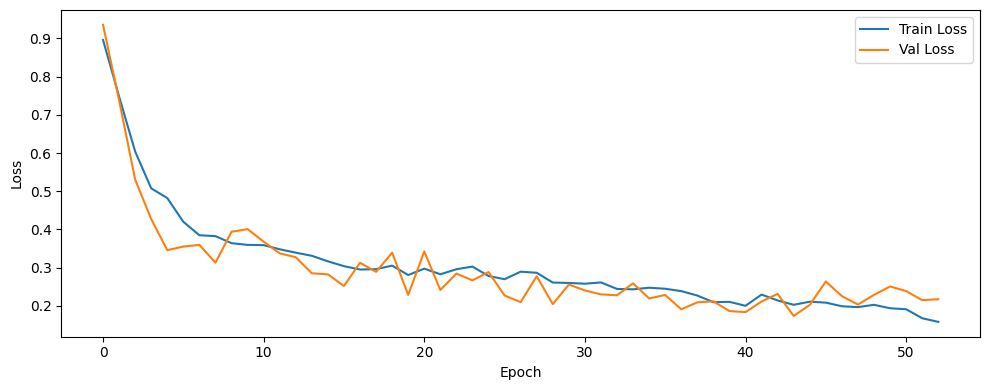

In [9]:
# Convert tensors in the lists to numbers if necessary
train_losses_cpu = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
val_losses_cpu = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in val_losses]

# Now plot these lists
plt.figure(figsize=(10, 4))
plt.plot(train_losses_cpu, label='Train Loss')
plt.plot(val_losses_cpu, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


Evaluation Results:
Balanced Accuracy2: 87.60%
Test Accuracy: 90.89%

Evaluation Results:
Accuracy: 90.89%
Precision: 91.06%
Recall: 90.89%
F1-score: 90.85%
Kappa: 85.53%
                         precision    recall  f1-score   support

            [Kreischen]       0.89      0.95      0.92       220
[Kreischen][Quietschen]       0.90      0.90      0.90        71
              [Negativ]       0.95      0.86      0.90       167
           [Quietschen]       0.85      0.79      0.81        14

               accuracy                           0.91       472
              macro avg       0.90      0.88      0.89       472
           weighted avg       0.91      0.91      0.91       472



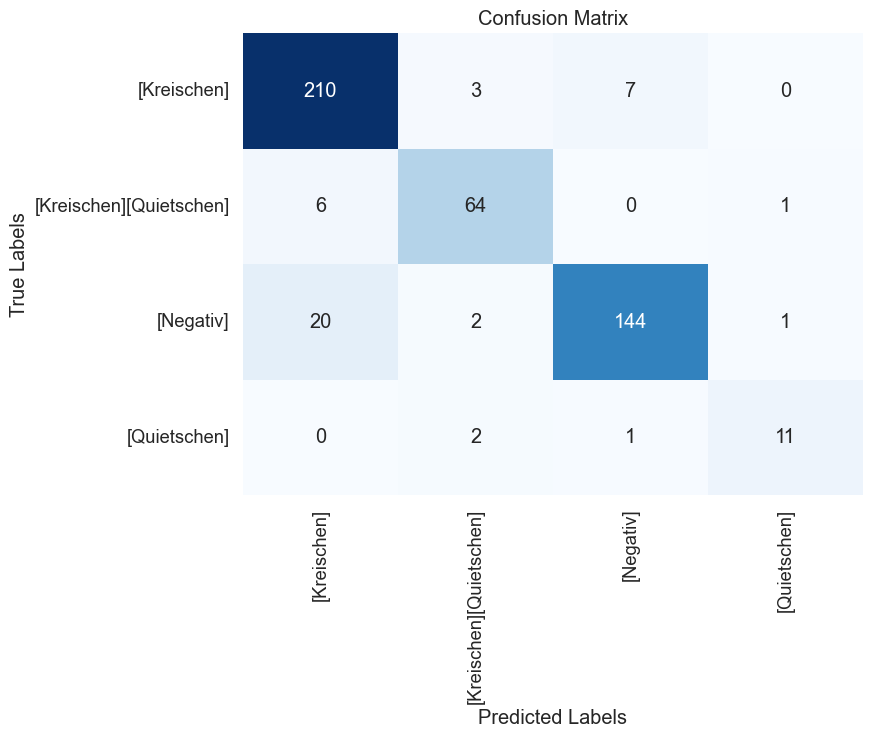

In [10]:

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support,balanced_accuracy_score
from sklearn.metrics import cohen_kappa_score

# and loaded any pre-trained weights, e.g., model = Resnet50_Classifier(num_classes)

# Set the device for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config.val_sound_length = 20
# Create a data loader for the test set
val_loader = DL.create_generators_finetune_val(val_df)  

#model = torch.load("./results_standalone/newgpu2_checkpoint.pth")
model = torch.load(standalone_results_path + '/Full_model_checkpoint.pth')
# Transfer the model to the testing device
model.to(device)

# Define a criterion for evaluation (e.g., cross-entropy loss for classification)
criterion = nn.CrossEntropyLoss()

# Initialize variables for evaluation metrics (e.g., accuracy)
correct_predictions = 0
total_samples = 0

# Define the label dictionary
true_labels_dic = {0: '[Kreischen]', 1: '[Kreischen][Quietschen]', 2: '[Negativ]', 3: '[Quietschen]'}

# Set the model to evaluation mode 
model.eval()

# Initialize lists to store all true labels and predicted labels
all_true_labels = []
all_predicted_labels = []

# Iterate through the test set
with torch.no_grad():
    for spectrograms, labels in val_loader:
        # Move data to the testing device
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        
        # Compute the predicted labels
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels to the lists
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)

# Calculate accuracy, precision, recall, F1-score, etc. using all_true_labels and all_predicted_labels
accuracy = np.mean(all_true_labels == all_predicted_labels)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted')


#calculate balanced accuracy
balanced_accuracy2 = balanced_accuracy_score(all_true_labels, all_predicted_labels)
#kappa score
cohens_kappa = cohen_kappa_score(all_true_labels, all_predicted_labels)


print(f"\nEvaluation Results:")
#print(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
print(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%")

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"\nEvaluation Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1_score * 100:.2f}%")
print(f"Kappa: {cohens_kappa * 100:.2f}%")

conf_mat = confusion_matrix(all_true_labels, all_predicted_labels)
def plot_confusion_matrix(conf_mat, class_labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    
    class_labels = [str(label) for label in class_labels]
    
    ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_labels,
                yticklabels=class_labels)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)

    return plt.gcf()  # Return the current figure

import config
#create classification results text file
with open(f'{standalone_results_path}/results_file_full.txt', 'w') as log_file:
    log_file.write(f"########################################################\n")
    log_file.write(f"Frequency Mask:{config.freq_mask_param}\n")
    log_file.write(f"Time Mask: {config.time_mask_param}\n")
    log_file.write(f"Spectro:\n")
    log_file.write(f"        n_fft={2048},\n")
    log_file.write(f"        hop_length = {512},\n")
    log_file.write(f"        n_mels={128},  \n")
    log_file.write(f"        win_length = {2048},\n")
    log_file.write(f"Epochs: {num_epochs}\n")
    log_file.write(f"Batch size: {batch_size}\n")
    log_file.write(f"Optimizer: Adam\n")
    log_file.write(f"Learning rate: {learning_rate}\n")
    log_file.write(f"Weight decay: {weight_decay}\n")
    log_file.write(f"Scheduler: ReduceLROnPlateau\n")
    log_file.write(f"Model: ModifiedResnet50_Classifier \n")
    log_file.write(f"classifiers: 512, 256, 4 : 2 fully connected layers\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%\n")
    log_file.write(f"Test Accuracy: {accuracy * 100:.2f}%\n")
    log_file.write(f"\nEvaluation Results:\n")
    log_file.write(f"Precision: {precision * 100:.2f}%\n")
    log_file.write(f"Recall: {recall * 100:.2f}%\n")
    log_file.write(f"F1-score: {f1_score * 100:.2f}%\n")
    log_file.write(f"Kappa: {cohens_kappa * 100:.2f}%\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Confusion Matrix:\n")
    log_file.write(f"{conf_mat}\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Classifcation Report: {classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values())}\n")

print(classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values()))

#save this plot as a png file
plot = plot_confusion_matrix(conf_mat, true_labels_dic.values())
plot.savefig(f'{standalone_results_path}/confusion_matrix_full.png')










Evaluation Results:
Balanced Accuracy2: 88.67%
Test Accuracy: 92.58%

Evaluation Results:
Accuracy: 92.58%
Precision: 92.60%
Recall: 92.58%
F1-score: 92.58%
Kappa: 88.25%
                         precision    recall  f1-score   support

            [Kreischen]       0.92      0.95      0.93       220
[Kreischen][Quietschen]       0.94      0.89      0.91        71
              [Negativ]       0.93      0.93      0.93       167
           [Quietschen]       0.79      0.79      0.79        14

               accuracy                           0.93       472
              macro avg       0.90      0.89      0.89       472
           weighted avg       0.93      0.93      0.93       472



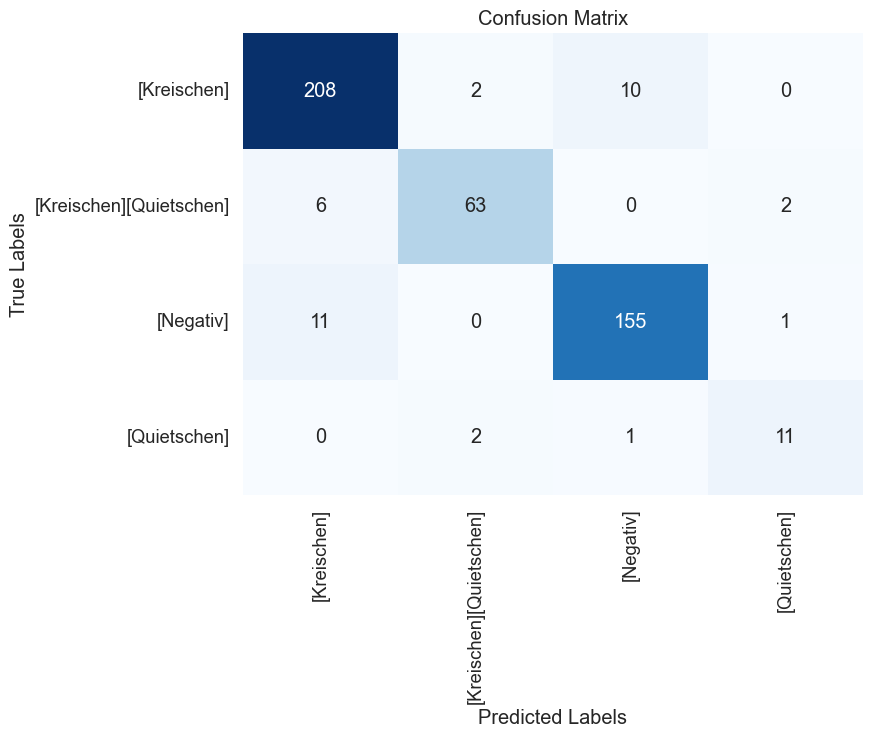

In [19]:

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support,balanced_accuracy_score
from sklearn.metrics import cohen_kappa_score

# and loaded any pre-trained weights, e.g., model = Resnet50_Classifier(num_classes)

# Set the device for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config.val_sound_length = 20
# Create a data loader for the test set
val_loader = DL.create_generators_finetune_val(val_df)  

#model = torch.load("./results_standalone/newgpu2_checkpoint.pth")
model = torch.load(standalone_results_path + '/checkpoint.pth')
# Transfer the model to the testing device
model.to(device)

# Define a criterion for evaluation (e.g., cross-entropy loss for classification)
criterion = nn.CrossEntropyLoss()

# Initialize variables for evaluation metrics (e.g., accuracy)
correct_predictions = 0
total_samples = 0

# Define the label dictionary
true_labels_dic = {0: '[Kreischen]', 1: '[Kreischen][Quietschen]', 2: '[Negativ]', 3: '[Quietschen]'}

# Set the model to evaluation mode 
model.eval()

# Initialize lists to store all true labels and predicted labels
all_true_labels = []
all_predicted_labels = []

# Iterate through the test set
with torch.no_grad():
    for spectrograms, labels in val_loader:
        # Move data to the testing device
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        
        # Compute the predicted labels
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels to the lists
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)

# Calculate accuracy, precision, recall, F1-score, etc. using all_true_labels and all_predicted_labels
#use sklearn  accuracy 
accuracy = np.mean(all_true_labels == all_predicted_labels)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted')


#calculate balanced accuracy
balanced_accuracy2 = balanced_accuracy_score(all_true_labels, all_predicted_labels)
#kappa score
cohens_kappa = cohen_kappa_score(all_true_labels, all_predicted_labels)


print(f"\nEvaluation Results:")
#print(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
print(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%")

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"\nEvaluation Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1_score * 100:.2f}%")
print(f"Kappa: {cohens_kappa * 100:.2f}%")

conf_mat = confusion_matrix(all_true_labels, all_predicted_labels)
def plot_confusion_matrix(conf_mat, class_labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    
    class_labels = [str(label) for label in class_labels]
    
    ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_labels,
                yticklabels=class_labels)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)

    return plt.gcf()  # Return the current figure

import config
#create classification results text file
with open(f'{standalone_results_path}/results_file_best.txt', 'w') as log_file:
    log_file.write(f"########################################################\n")
    log_file.write(f"Frequency Mask:{config.freq_mask_param}\n")
    log_file.write(f"Time Mask: {config.time_mask_param}\n")
    log_file.write(f"Spectro:\n")
    log_file.write(f"        n_fft={2048},\n")
    log_file.write(f"        hop_length = {512},\n")
    log_file.write(f"        n_mels={128},  \n")
    log_file.write(f"        win_length = {2048},\n")
    log_file.write(f"Epochs: {num_epochs}\n")
    log_file.write(f"Batch size: {batch_size}\n")
    log_file.write(f"Optimizer: Adam\n")
    log_file.write(f"Learning rate: {learning_rate}\n")
    log_file.write(f"Weight decay: {weight_decay}\n")
    log_file.write(f"Scheduler: ReduceLROnPlateau\n")
    log_file.write(f"Model: ModifiedResnet50_Classifier \n")
    log_file.write(f"classifiers: 512, 256, 4 : 2 fully connected layers\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%\n")
    log_file.write(f"Test Accuracy: {accuracy * 100:.2f}%\n")
    log_file.write(f"\nEvaluation Results:\n")
    log_file.write(f"Precision: {precision * 100:.2f}%\n")
    log_file.write(f"Recall: {recall * 100:.2f}%\n")
    log_file.write(f"F1-score: {f1_score * 100:.2f}%\n")
    log_file.write(f"Kappa: {cohens_kappa * 100:.2f}%\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Confusion Matrix:\n")
    log_file.write(f"{conf_mat}\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Classifcation Report: {classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values())}\n")

print(classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values()))

#save this plotas a png file
plot = plot_confusion_matrix(conf_mat, true_labels_dic.values())
plot.savefig(f'{standalone_results_path}/confusion_matrix_best.png')










Evaluation Results:
Balanced Accuracy2: 87.55%
Test Accuracy: 92.80%

Evaluation Results:
Accuracy: 92.80%
Precision: 92.77%
Recall: 92.80%
F1-score: 92.76%
Kappa: 88.59%
                         precision    recall  f1-score   support

            [Kreischen]       0.92      0.95      0.94       220
[Kreischen][Quietschen]       0.92      0.92      0.92        71
              [Negativ]       0.94      0.92      0.93       167
           [Quietschen]       0.83      0.71      0.77        14

               accuracy                           0.93       472
              macro avg       0.90      0.88      0.89       472
           weighted avg       0.93      0.93      0.93       472



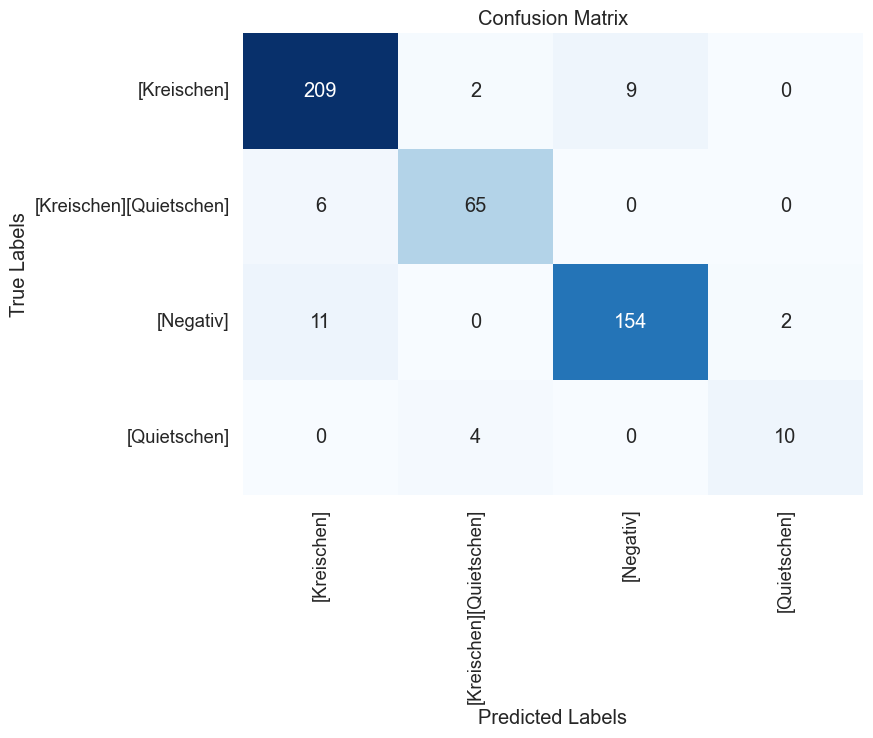

In [22]:

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support,balanced_accuracy_score
from sklearn.metrics import cohen_kappa_score

# and loaded any pre-trained weights, e.g., model = Resnet50_Classifier(num_classes)

# Set the device for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config.val_sound_length = 20
# Create a data loader for the test set
val_loader = DL.create_generators_finetune_val(val_df)  

#model = torch.load("./results_standalone/newgpu2_checkpoint.pth")
model = torch.load(standalone_results_path + '/checkpoint_best_loss.pth')
# Transfer the model to the testing device
model.to(device)

# Define a criterion for evaluation (e.g., cross-entropy loss for classification)
criterion = nn.CrossEntropyLoss()

# Initialize variables for evaluation metrics (e.g., accuracy)
correct_predictions = 0
total_samples = 0

# Define the label dictionary
true_labels_dic = {0: '[Kreischen]', 1: '[Kreischen][Quietschen]', 2: '[Negativ]', 3: '[Quietschen]'}

# Set the model to evaluation mode 
model.eval()

# Initialize lists to store all true labels and predicted labels
all_true_labels = []
all_predicted_labels = []

# Iterate through the test set
with torch.no_grad():
    for spectrograms, labels in val_loader:
        # Move data to the testing device
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        
        # Compute the predicted labels
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels to the lists
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)

# Calculate accuracy, precision, recall, F1-score, etc. using all_true_labels and all_predicted_labels
#use sklearn  accuracy 
accuracy = np.mean(all_true_labels == all_predicted_labels)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted')


#calculate balanced accuracy
balanced_accuracy2 = balanced_accuracy_score(all_true_labels, all_predicted_labels)
#kappa score
cohens_kappa = cohen_kappa_score(all_true_labels, all_predicted_labels)


print(f"\nEvaluation Results:")
#print(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
print(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%")

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"\nEvaluation Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1_score * 100:.2f}%")
print(f"Kappa: {cohens_kappa * 100:.2f}%")

conf_mat = confusion_matrix(all_true_labels, all_predicted_labels)
def plot_confusion_matrix(conf_mat, class_labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    
    class_labels = [str(label) for label in class_labels]
    
    ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_labels,
                yticklabels=class_labels)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)

    return plt.gcf()  # Return the current figure

import config
#create classification results text file
with open(f'{standalone_results_path}/results_file_best.txt', 'w') as log_file:
    log_file.write(f"########################################################\n")
    log_file.write(f"Frequency Mask:{config.freq_mask_param}\n")
    log_file.write(f"Time Mask: {config.time_mask_param}\n")
    log_file.write(f"Spectro:\n")
    log_file.write(f"        n_fft={2048},\n")
    log_file.write(f"        hop_length = {512},\n")
    log_file.write(f"        n_mels={128},  \n")
    log_file.write(f"        win_length = {2048},\n")
    log_file.write(f"Epochs: {num_epochs}\n")
    log_file.write(f"Batch size: {batch_size}\n")
    log_file.write(f"Optimizer: Adam\n")
    log_file.write(f"Learning rate: {learning_rate}\n")
    log_file.write(f"Weight decay: {weight_decay}\n")
    log_file.write(f"Scheduler: ReduceLROnPlateau\n")
    log_file.write(f"Model: ModifiedResnet50_Classifier \n")
    log_file.write(f"classifiers: 512, 256, 4 : 2 fully connected layers\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%\n")
    log_file.write(f"Test Accuracy: {accuracy * 100:.2f}%\n")
    log_file.write(f"\nEvaluation Results:\n")
    log_file.write(f"Precision: {precision * 100:.2f}%\n")
    log_file.write(f"Recall: {recall * 100:.2f}%\n")
    log_file.write(f"F1-score: {f1_score * 100:.2f}%\n")
    log_file.write(f"Kappa: {cohens_kappa * 100:.2f}%\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Confusion Matrix:\n")
    log_file.write(f"{conf_mat}\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Classifcation Report: {classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values())}\n")

print(classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values()))

#save this plotas a png file
plot = plot_confusion_matrix(conf_mat, true_labels_dic.values())
plot.savefig(f'{standalone_results_path}/confusion_matrix_best_loss.png')







